Please be aware that this notebook is a work in progress, features and model parameters are not yet perfectly tuned.

### Import libraries

In [1]:
import sys
!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

print('rapids ai installed')

rapids ai installed


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.ticker as tic
import matplotlib
import datetime

import re
from itertools import product
from catboost import Pool, CatBoostRegressor,CatBoostClassifier

from sklearn.metrics               import mean_squared_error
from sklearn.preprocessing         import StandardScaler
from sklearn.ensemble              import RandomForestRegressor
from sklearn.linear_model          import LinearRegression

import cudf, cuml, cupy
from cuml.neighbors import KNeighborsRegressor 

pd.plotting.register_matplotlib_converters()
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
max_width = 12
import warnings
warnings.filterwarnings('ignore')

print('all libraries imported')

all libraries imported


# Overview

In [3]:
path = '../input/competitive-data-science-predict-future-sales/'

f_categories      = pd.read_csv(path + 'item_categories.csv')
f_items           = pd.read_csv(path + 'items.csv')
f_transactions    = pd.read_csv(path + 'sales_train.csv')
f_sample          = pd.read_csv(path + 'sample_submission.csv')
f_shops           = pd.read_csv(path + 'shops.csv')
f_test            = pd.read_csv(path + 'test.csv')

#### Available data:

We have almost 3 years of transactions from several 1C shops, aggregated daily:

In [4]:
f_transactions.date    = pd.to_datetime(f_transactions.date, format = '%d.%m.%Y')

f_sales = f_transactions\
.join(f_items.set_index('item_id'), on='item_id')\
.join(f_categories.set_index('item_category_id'), on='item_category_id')\
.join(f_shops.set_index('shop_id'), on='shop_id')

f_sales.head(2).T

,0,1
date,2013-01-02 00:00:00,2013-01-03 00:00:00
date_block_num,0,0
shop_id,59,25
item_id,22154,2552
item_price,999,899
item_cnt_day,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
item_category_id,37,58
item_category_name,Кино - Blu-Ray,Музыка - Винил
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""


#### What is in test sample:

In [5]:
f_test\
.join(f_sample.set_index('ID'), on='ID').head()

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.5
1,1,5,5320,0.5
2,2,5,5233,0.5
3,3,5,5232,0.5
4,4,5,5268,0.5


#### How to form evaluation sample:

In [6]:
pd.pivot_table(f_sales.loc[f_sales.date_block_num==33], index='item_id', columns='shop_id', values='item_cnt_day', aggfunc='sum')\
.clip(0,20).fillna(0)\
.unstack().to_frame('item_cnt_month').reset_index().head()

,shop_id,item_id,item_cnt_month
0,2,30,0.0
1,2,31,1.0
2,2,32,0.0
3,2,33,0.0
4,2,40,0.0


#### First look - item sales per shop per day in relative numbers as a heatmap

Some conclusions that we may make from the plot below:
* shops open and close, may be closed for a day or a month
* some shops may have wrong id's (id 0,1 vs 57,58, and 10 vs 11)
* shops differ in type, some are seasonal sales (id 9 and 20)
* not all shops are in test, but some are stable and may give extra info (for example id 29,30,54)
* when looking at the demand over time, closed shops may distort the picture

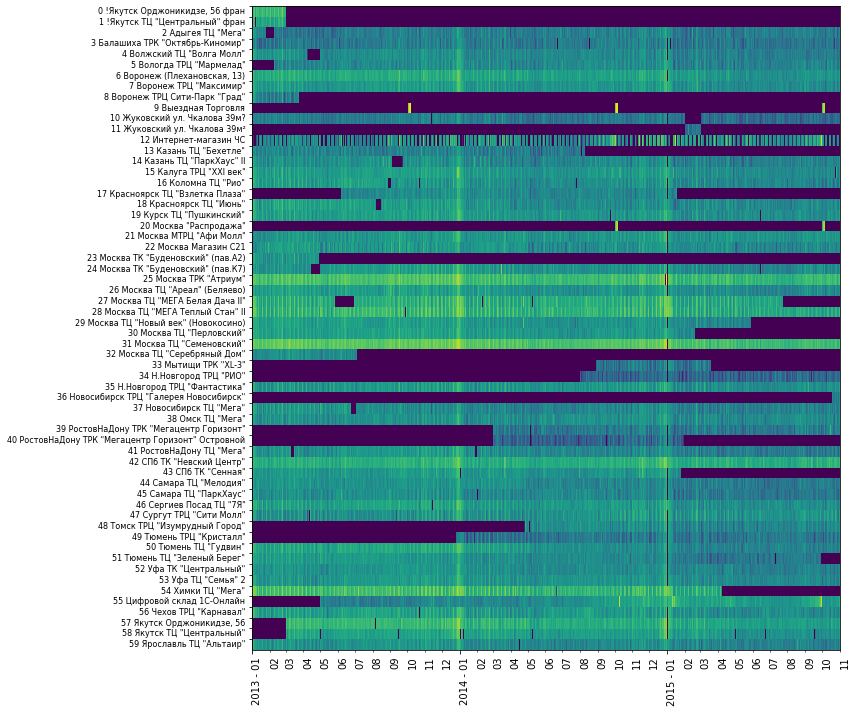

In [7]:
#data
piv = np.log(pd.pivot_table(f_sales,
                            index='date',
                            columns=['shop_id','shop_name'],
                            values='item_cnt_day',
                            aggfunc='sum').fillna(0).clip(0,)+1).T

#plotting

fig, ax = plt.subplots(figsize=(max_width,10))

_y = piv.index.get_level_values(0)[::-1]
_x = mdates.date2num(piv.columns)
    
ax.imshow(piv, aspect='auto', extent = [ _x[0],  _x[-1]+1,  _y[0]+1, _y[-1]], interpolation='none')

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y - %m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

ax.yaxis.set_ticks(_y)
ax.set_yticklabels(piv.index.get_level_values(0)[::-1].astype('str') + ' ' + piv.index.get_level_values(1)[::-1],
                  fontsize=8, va='top')

fig.autofmt_xdate(which='both', rotation=90, ha='left')


plt.tight_layout()
plt.show()

## Preprocessing

Basic preprocessing for future EDA needs, with comments in code:

In [8]:
test = f_test.copy()

In [9]:
#prepare transactions

f_transactions.date    = pd.to_datetime(f_transactions.date, format = '%d.%m.%Y')
transactions = f_transactions.copy()

#---------------------------------------------------------------------------
#some handpicked outliers:
transactions = transactions.loc[~transactions.index.isin([1573253,1573252,1618930,1571406,2909818,1829149,1088966])]

#---------------------------------------------------------------------------
# filtering for clipping to speed up process and not to distort items with small ammount of sales
#a = transactions.groupby('item_id').agg(sales_sum=('item_cnt_day','sum'),
#                                        sales_mean=('item_cnt_day','mean'),
#                                        sales_max=('item_cnt_day','max'),)\
#.assign(max_to_mean=(lambda x: x.sales_max/x.sales_mean))\
#.loc[lambda x: (x.sales_sum>20)&(x.sales_max>10)&(x.max_to_mean>2)]\
#.index

#for i in a:
#    _ = transactions.loc[transactions.item_id==i,'item_cnt_day']
#    transactions.loc[transactions.item_id==i,'item_cnt_day'] = _.clip(upper=_[_>0].quantile(0.98))
    
#---------------------------------------------------------------------------   
#clip more and  fix shop id's

#transactions.item_cnt_day = transactions.item_cnt_day.clip(upper=100)
#transactions.shop_id = transactions.shop_id.replace([0,1,11],[57,58,10])

#---------------------------------------------------------------------------   

transactions['year']            = transactions.date.dt.year
transactions['month']           = transactions.date.dt.month
transactions['day']             = transactions.date.dt.day
transactions['day_of_year']     = transactions.date.dt.dayofyear
transactions['week_day']        = transactions.date.dt.weekday
transactions['activity_cnt']    = transactions.item_cnt_day.abs()
transactions['activity_rev']    = transactions.activity_cnt*transactions.item_price
transactions['revenue']         = transactions.item_cnt_day*transactions.item_price

In [10]:
#prepare items

items = f_items.copy()

#---------------------------------------------------------------------------   
#separating plastic bag item from accessories to a separate category
items.at[20949,'item_category_id'] = 84

#only item from PC category, move to ps accessories
items.at[5441,'item_category_id'] = 3

#---------------------------------------------------------------------------   

items = items\
.join(transactions.groupby('item_id').agg(
    sale_start=('date','min'),
    sale_end=('date','max'),
    price_mean=('item_price','mean'),
    #sales_cnt=('item_cnt_day','sum'),
    item_total_revenue=('revenue','sum'),
))

In [11]:
#prepare categories

categories = f_categories.copy()

#---------------------------------------------------------------------------   
#separating plastic bag item from accessories to a separate category

categories = categories.append({'item_category_name': 'Фирменный пакет','item_category_id': 84,}, ignore_index=True)

# global category level

categories['cat_global'] = np.select(
    [categories.item_category_id.isin(range(0,8)),
    categories.item_category_id.isin([8,80]),
    categories.item_category_id==9,
    categories.item_category_id.isin(range(10,18)),
    categories.item_category_id.isin(range(18,32)),
    categories.item_category_id.isin([32,33,34,35,36,37,79]),
    categories.item_category_id.isin(range(37,42)),
    categories.item_category_id.isin(range(42,55)),
    categories.item_category_id.isin(range(55,61)),
    categories.item_category_id.isin(range(61,73)),
    categories.item_category_id.isin(range(73,79)),
    categories.item_category_id.isin([81,82]),
    categories.item_category_id==83,
    categories.item_category_id==84],    
    ['accessories','tickets','delivery','consoles','games',
    'payment_cards','movies','books','music','gifts','programs',
     'discs','batteries','plastic_bags'])

# subcategories by platform

categories['cat_platform'] = np.select(
    [categories.item_category_name.str.contains('PS2'),
    categories.item_category_name.str.contains('PS3'),
    categories.item_category_name.str.contains('PS4'),
    categories.item_category_name.str.contains('PSP'),
    categories.item_category_name.str.contains('PSVita'),
    categories.item_category_name.str.contains('XBOX 360'),
    categories.item_category_name.str.contains('XBOX ONE'),
    categories.item_category_name.str.contains('PC'),
    categories.item_category_name.str.contains('MAC'),
    categories.item_category_name.str.contains('Android')],
    ['PS2','PS3','PS4','PSP','PSVita','XBOX_360','XBOX_ONE','PC','MAC','Android'],
    default='other')

# digital subcategory

categories['cat_digital'] = categories.item_category_name\
.str.contains('Цифра')*1

# marking categories that are in test set

categories['cat_in_test'] = categories.item_category_id\
.isin(test.set_index('item_id').join(items.item_category_id).item_category_id)*1

# that are too scattered or not standard for training

categories['cat_to_drop'] = categories.item_category_id\
.isin([ 1,8,10,13,17,18,39,46,48,50,51,52,53,66,68,80,81,82])*1

In [12]:
#prepare shops

shops = f_shops.copy()

#---------------------------------------------------------------------------   
#droppin dublicates, marking shops in test, marking shops that are unsuitable to train
shops = shops.loc[~shops.shop_id.isin([0,1,11])]
shops['shop_in_test'] = shops.shop_id.isin(test.shop_id)*1
shops['shop_to_drop'] = shops.shop_id.isin([8,9,20,23,32,33,40])*1

#---------------------------------------------------------------------------   
# querying city name from shop name

split = shops['shop_name'].\
str.replace('Н.Новгород','ННовгород').\
str.replace('Сергиев Посад','СергиевПосад').\
str.replace('\W+',' ').\
str.strip().\
str.split(' ', 1).\
str
    
shops['shop_city'] = split[0]
shops['shop_name_part'] = split[1]

#---------------------------------------------------------------------------   
# calculating relative shop average sales, for further analysis

sold_items_cnt_per_work_day = transactions.groupby(['shop_id']).item_cnt_day.sum()/transactions.groupby(['shop_id']).date.nunique()
shops = shops.join((sold_items_cnt_per_work_day/sold_items_cnt_per_work_day.mean()).to_frame('shop_size'))

After preprocessing is done I combine everything into one dataframe.

In [13]:
sales = transactions\
.join(items.set_index('item_id'), on='item_id')\
.join(categories.set_index('item_category_id'), on='item_category_id')\
.join(shops.set_index('shop_id'), on='shop_id')\
.loc[lambda x: (x.cat_to_drop==0)&(x.shop_to_drop==0)]

## Seasonality

Since the ammount of opened and closed shops is different all the time, to separate seasonal effects I adjust item sales by the ammount and size of shops that are opened at any given point:

In [14]:
_ = sales.groupby('date').shop_id.nunique()

sales = sales\
.set_index('date')\
.join(_.to_frame('shops_opened'))\
.reset_index()\
.assign(shop_compensation = lambda x: (x.shop_size*x.shops_opened)/(_.mean()))\
.assign(item_cnt_day_sw = lambda x: x.item_cnt_day/x.shop_compensation)

It is also oblious that different catgories and shops will have different seasonalities, lets look at it first: 

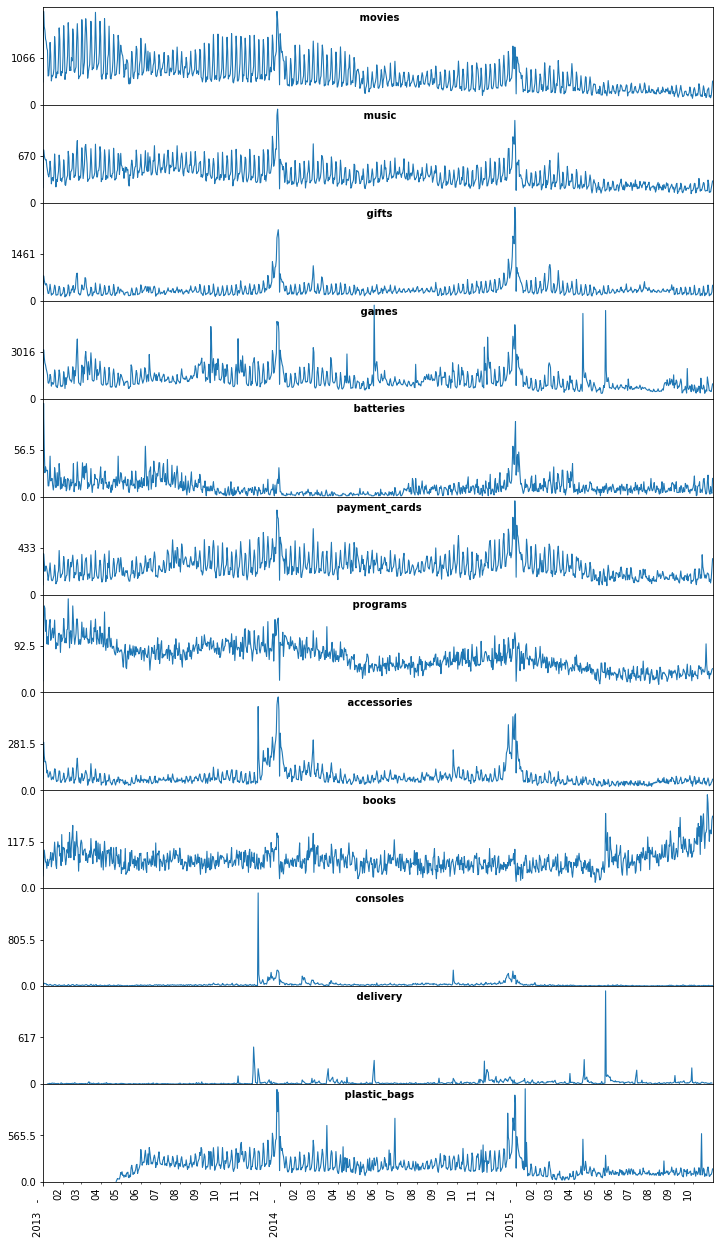

In [15]:
fig, ax = plt.subplots(sales.cat_global.nunique(),sharex=True,figsize=(max_width,sales.cat_global.nunique()*2))
start = datetime.date(2013,1,1)
end = datetime.date(2015,10,31)

for i,j in enumerate(sales.cat_global.unique()):
    
    plt.subplots_adjust(hspace=0)
    
    view = sales.loc[(sales.cat_global==j)].groupby('date').item_cnt_day.sum().clip(0,)

    ax[i].plot(view, linewidth=1.1)  
    ax[i].set_title(' '+j, loc='center', fontsize=10, y=0.8, fontweight='bold')
    ax[i].set_xlim([start,end])
    
    ax[i].set_ylim(0,)
    ax[i].yaxis.set_major_locator(tic.FixedLocator([0,view.max()/2]))
    
    ax[i].xaxis.set_major_locator(mdates.YearLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y   -   '))
    
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator())
    ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

fig.autofmt_xdate(which='both',rotation=90)

I see clear weekly trends, but monthly seasonality is also possible. From the charts below we can make an important note - for future cross validation:
since weekly seasonality is stronger it is better to use 30 day training splits with the same ammount of weekdays, instead of using default monthly split.

In [16]:
m = sales.loc[(~sales.month.isin([12,1,2]))&(sales.day!=31)]\
.groupby('day').item_cnt_day_sw.sum()
m = m/m.mean()

_ = sales.loc[~sales.month.isin([12,1])]\
.groupby(['cat_global','week_day'])\
.item_cnt_day_sw.sum().unstack().T

weekly_cat = _.div(_.mean())

sales = sales\
.set_index(['cat_global','week_day'])\
.join(weekly_cat.loc[:,weekly_cat.columns!='delivery'].unstack().to_frame('week_day_effect_cat'), how='left')\
.fillna(value={'week_day_effect_cat':1})\
.reset_index()\
.assign(item_cnt_day_sw=lambda x: x.item_cnt_day_sw/x.week_day_effect_cat)

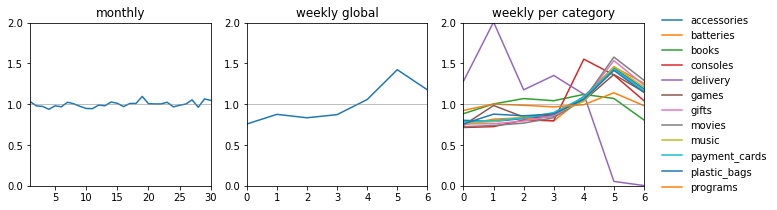

In [17]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(max_width-1,3))

ax[0].plot(m)
ax[1].plot(_.T.mean().div(_.T.mean().mean()))
ax[2].plot(_.div(_.mean()))

ax[0].axhline(1, linestyle='-', color='gray', linewidth=0.5)
ax[1].axhline(1, linestyle='-', color='gray', linewidth=0.5)
ax[2].axhline(1, linestyle='-', color='gray', linewidth=0.5)

ax[0].set_title('monthly')
ax[1].set_title('weekly global')
ax[2].set_title('weekly per category')

ax[1].tick_params(labelleft=True)
ax[2].tick_params(labelleft=True)

ax[0].set_ylim(0,2)

ax[0].yaxis.set_major_locator(tic.LinearLocator(numticks=5))

ax[0].set_xlim(1,30)
ax[1].set_xlim(0,6)
ax[2].set_xlim(0,6)

ax[2].legend(_.columns,
             loc='center left', 
             bbox_to_anchor=(1.05, 0.5), 
             frameon=False)

plt.show()

One more thing that we may notice from spikes is that sales count depends on days passed after release date. Separating this effect will make seasonality less noisy.  

In [18]:
sales['days_from_sale_start'] = (sales.date-sales.sale_start).dt.days

_ = sales.loc[(sales.sale_start>=datetime.datetime(2013, 6, 1))
             &(~sales.cat_global.isin(['delivery']))
             &(sales.days_from_sale_start<=60)] 

_ = pd.pivot_table(_,
               index=['cat_global','item_id'],
               columns='days_from_sale_start',
               values='item_cnt_day_sw',
               aggfunc='sum').fillna(0).reset_index()\
.drop('item_id',axis=1) 


new_item_effect_cat = (_.groupby('cat_global').mean()).div((_.groupby('cat_global').mean()).mean(axis=1),axis=0).T
new_item_effect_cat = new_item_effect_cat.div(new_item_effect_cat.tail(20).mean())

new_item_effect_glob  = (_.mean()/(_.mean().mean())).T
new_item_effect_glob = new_item_effect_glob.div(new_item_effect_glob.tail(20).mean())

sales = sales\
.set_index(['cat_global','days_from_sale_start'])\
.join(new_item_effect_cat.unstack().to_frame('new_item_effect_cat'), how='left')\
.fillna(value={'new_item_effect_cat':1})\
.reset_index()\
.assign(item_cnt_day_sw=lambda x: x.item_cnt_day_sw/x.new_item_effect_cat)

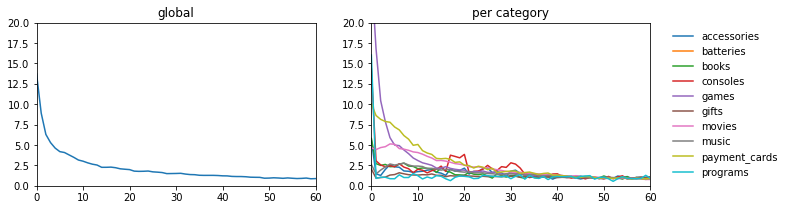

In [19]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(max_width-1,3))

ax[0].plot(new_item_effect_glob)
ax[1].plot(new_item_effect_cat)

ax[1].tick_params(labelleft=True)


ax[0].set_title('global')
ax[1].set_title('per category')


ax[0].set_ylim(0,20)
ax[0].set_xlim(0,60)

ax[1].legend(new_item_effect_cat.columns,
             loc='center left', 
             bbox_to_anchor=(1.05, 0.5), 
             frameon=False)

plt.show()

Overall sales trend looks to be declining, so I calculate relative year size to adjust sales count. 

In [20]:
year_size = sales.loc[~sales.month.isin([1,2,11,12])].groupby('year').item_cnt_day_sw.sum()\
.div(sales.loc[~sales.month.isin([1,2,11,12]),'item_cnt_day_sw'].sum()).multiply(3).to_frame('year_size')

sales = sales.set_index('year')\
.join(year_size).reset_index()\
.assign(item_cnt_day_sw=lambda x: x.item_cnt_day_sw/x.year_size)

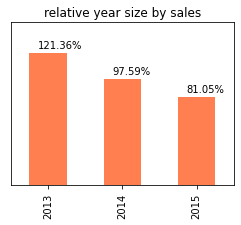

In [21]:
ax = year_size.plot(kind='bar', color="coral", fontsize=10, legend=False, figsize=(4,3));
ax.set_alpha(0.8)
ax.set_ylim(0,1.5)
ax.set_xlabel(None)
ax.set_title('relative year size by sales')


ax.axes.get_yaxis().set_visible(False)


for i in ax.patches:
    ax.text(i.get_x()+.11, i.get_height()+.05, \
            str(round((i.get_height())*100, 2))+'%')

After adjusting sales to all the effects above we finally may calculate annual seasonality, global and for each category.
Since we had only 3 years, weekly fluctuations are slightly visible.
National holidays are clearly visible aswell.

In [22]:
_ = sales.loc[(sales.cat_global!='delivery')&(sales.date>=datetime.datetime(2013, 3, 1))]\
.groupby(['cat_global','year','day_of_year']).item_cnt_day_sw.sum()\
.groupby(['cat_global','day_of_year']).mean()

sales = sales\
.set_index(['cat_global','day_of_year'])\
.join(_.unstack().T.div(_.unstack().T.mean()).unstack().to_frame('seasonality_annual_cat'), how='left')\
.fillna(value={'seasonality_annual_cat':1})\
.reset_index()

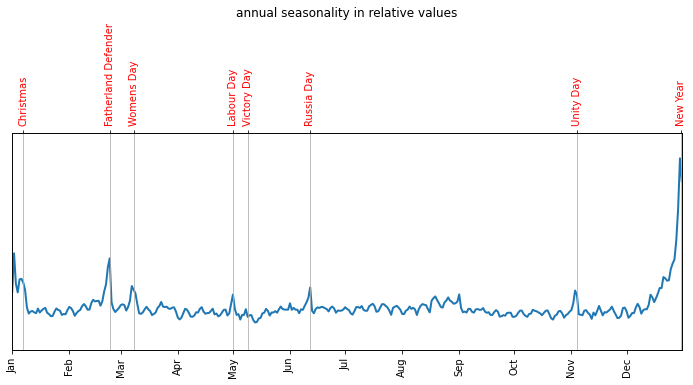

In [23]:
fig, ax = plt.subplots(figsize=(max_width,4))


_ = sales.loc[sales.cat_global!='delivery']\
.groupby(['year','day_of_year']).item_cnt_day_sw.sum()\
.groupby(['day_of_year']).mean()

_=_/_.mean()

ax.plot(_, linewidth=2)

ax.set_xticks([1,32,60,91,121,152,182,213,244,274,305,335])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation=90)

ax2 = ax.twiny()
ax2.set_xlim(1,365)
ax2.set_xticks([7,54,67,121,129,163,308,364.5])
ax2.set_xticklabels(['Christmas','Fatherland Defender',
                     'Womens Day','Labour Day',
                     'Victory Day','Russia Day',
                     'Unity Day','New Year'],rotation=90,color='red')

ax2.xaxis.grid(True, which='major')

ax.set_xlim(1,365)
ax.set_ylim(0,5)

ax.axes.get_yaxis().set_visible(False)
ax.set_title('annual seasonality in relative values')

plt.show()

Now it is possible to calculate deaseasonalized item sales count:

In [24]:
sales['item_cnt_day_deseasoned'] = sales.item_cnt_day\
                                .div(sales.week_day_effect_cat)\
                                .div(sales.seasonality_annual_cat)

It is also interesting how price affect sales. For example temporary actions are launched for games and usually are a "plain discount" or "buy one get other for free" type.
List of all actions may be found here: https://www.1c-interes.ru/special_actions 

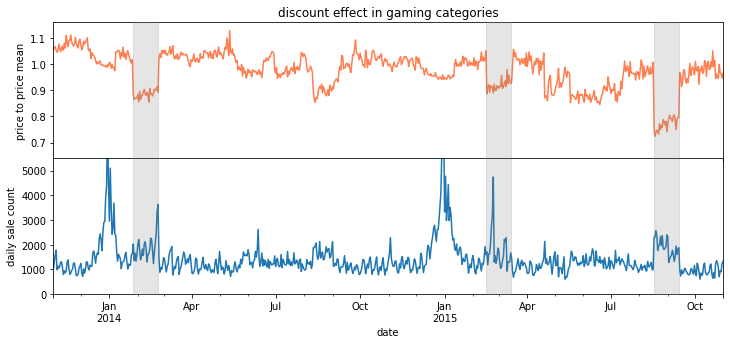

In [25]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(max_width,5))

cond1 = (sales.date>=datetime.datetime(2013, 11, 1))&(sales.cat_global=='games')
cond2 = (sales.date>=datetime.datetime(2013, 11, 1))&(sales.cat_global!='games')

sales.loc[cond1].assign(price_to_mean=sales.item_price/sales.price_mean)\
.groupby('date').price_to_mean.mean()\
.div(sales.loc[cond2].assign(price_to_mean=sales.item_price/sales.price_mean)\
.groupby('date').price_to_mean.mean())\
.plot(ax=ax1,color='coral')

plt.subplots_adjust(hspace=0)

sales.loc[cond1]\
.groupby('date').item_cnt_day_sw.sum()\
.plot(ax=ax2)   

ax1.set_ylim(0.64,1.16)
ax2.set_ylim(0,5500)

ax1.set_ylabel('price to price mean')
ax2.set_ylabel('daily sale count')


fig.patches.extend([plt.Rectangle((0.82,0.125),0.029,0.757,
                                  fill=True, color='gray', alpha=0.2,
                                  transform=fig.transFigure, figure=fig)])

fig.patches.extend([plt.Rectangle((0.626,0.125),0.029,0.757,
                                  fill=True, color='gray', alpha=0.2,
                                  transform=fig.transFigure, figure=fig)])

fig.patches.extend([plt.Rectangle((0.217,0.125),0.029,0.757,
                                  fill=True, color='gray', alpha=0.2,
                                  transform=fig.transFigure, figure=fig)])


ax1.set_title('discount effect in gaming categories')

plt.show()

Visualizing the data that will be used for training:

In [26]:
######
sales = sales.loc[(sales.shop_in_test==1)] #(sales.shop_id!=36)&

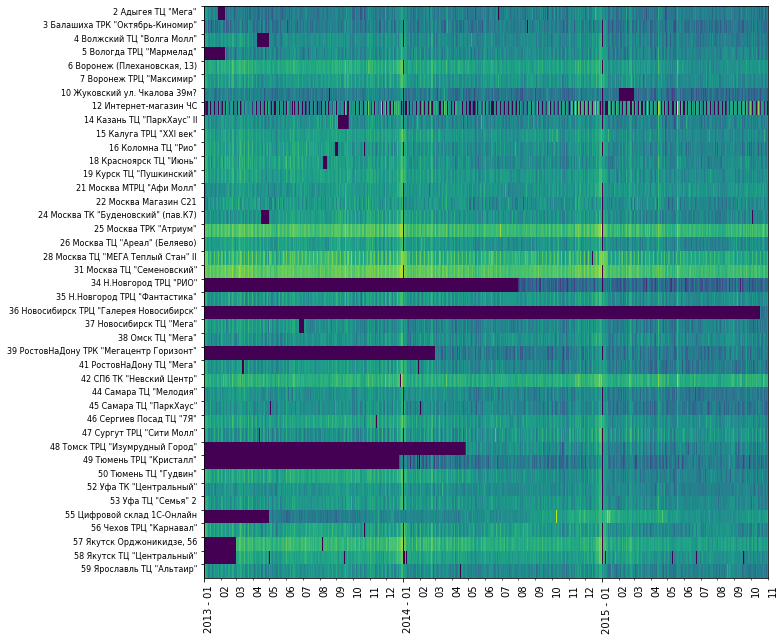

In [27]:
#data
piv = np.log(pd.pivot_table(sales,
                            index='date',
                            columns=['shop_id','shop_name'],
                            values='item_cnt_day',
                            aggfunc='sum').fillna(0).clip(0,)+1).T

#plotting

fig, ax = plt.subplots(figsize=(max_width-1,9))

_y = list(range(piv.shape[0]))[::-1]
_x = mdates.date2num(piv.columns)
    
ax.imshow(piv, aspect='auto', extent = [ _x[0],  _x[-1]+1,  _y[0]+1, _y[-1]], interpolation='none')

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y - %m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

ax.yaxis.set_ticks(_y)
ax.set_yticklabels(piv.index.get_level_values(0)[::-1].astype('str') + ' ' + piv.index.get_level_values(1)[::-1],
                  fontsize=8, va='top')

fig.autofmt_xdate(which='both', rotation=90, ha='left')


plt.tight_layout()
plt.show()

In [28]:
del f_sales,transactions,f_transactions

# Feature engineering

In the cells below I form time blocks and generate relateg features. The code is more or less readablee: 

In [29]:
def get_monthly_list(n):  
    #generate n blocks of days, n0 is test november, n+ are preceding month
    
    L=[0]*n
    for i in range(n):
        L[i]=pd.date_range(start=pd.Timestamp(2015, 11-i, 1), end=pd.Timestamp(2015, 12-i, 1),closed='left').values
    return L

def get_30d_list(n):
    #generate n blocks of days, n0 is test november, n+ are preceding 30 day intervals from 27th of september, 
    #each shifting 7 days back 
    
    L=[0]*n
    L[0]=pd.date_range(pd.Timestamp(2015, 11, 1), freq='D', periods=30).values
    for i in range(n-1):
        L[i+1]=pd.date_range(pd.Timestamp(2015, 9, 27), freq='D', periods=30).values-np.timedelta64(14*i, 'D')
    return L

def get_grid(sales,L):
    #generate n blocks of days, n0 is test november, n+ are preceding 30 day intervals from 27th of september, 
    #each shifting 7 days back 
    
    index_cols = ['shop_id', 'item_id', 'date_block']
    grid = [] 
    for i in range(len(L)-1):
        cur_shops  = sales[sales.date.isin(L[i+1])]['shop_id'].unique()
        cur_items  = sales[sales.date.isin(L[i+1])]['item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [i+1]])),dtype='int32'))


    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)\
            .append(test.loc[:,['shop_id','item_id']].assign(date_block=0))
    return grid

In [30]:
def get_features_normal(grid,L):
    date_length_max = (np.datetime64(L[-1][0],'D')-np.datetime64('2013-01-01','D'))

    X=[0]*len(L)
    y=[0]*len(L)

    for block in range(len(L)):
        date_start = L[block][0]
        
        col_drop = ['shop_in_test',  
                    'item_category_name',
                    'cat_to_drop',
                    'shop_name',
                    'shop_name_part',
                    'cat_in_test',
                    'shop_to_drop'
                    ] #,

        data = sales.loc[(sales.date<date_start) & (sales.date>=date_start-date_length_max),
                         ~sales.columns.isin(col_drop)]

        X_temp = grid.loc[grid.date_block==block]\
                .join(items.loc[:,items.columns.isin(['item_id','item_category_id'])].set_index('item_id'), on='item_id')\
                .join(categories.set_index('item_category_id'), on='item_category_id')\
                .join(shops.set_index('shop_id'), on='shop_id')\
                .loc[:,lambda x : ~x.columns.isin(col_drop)]
        

#--------------------------------------------------
        

# date features, first/last item sale in shop and global: 
        
        lt = len(X_temp.columns)
        X_temp = X_temp\
                .join(data.groupby('item_id')\
                      .agg(days_first_item_sold_glob=('date','min'),
                           days_last_item_sold_glob=('date','max')),
                      on='item_id')\
                .join(data.groupby(['item_id','shop_id'])\
                      .agg(days_first_item_sold_shop=('date','min'),
                           days_last_item_sold_shop=('date','max')),
                      on=['item_id','shop_id'])\
        
        
        
        X_temp.iloc[:,lt:] = ((date_start-X_temp.iloc[:,lt:])/np.timedelta64(1, 'D')).fillna(-1)
        
        
#--------------------------------------------------        
# global features: 

        X_temp = X_temp\
                .join(data.groupby('item_id')\
                       .agg(item_price_mean=('item_price','mean')),
                      on='item_id')\
                .join(data.groupby('item_category_id')\
                       .agg(cat_price_mean=('item_price','mean')),
                      on='item_category_id')\
        
        X_temp = X_temp.assign(new_item = lambda x: x.item_price_mean.isna()*1)
        
        X_temp.loc[X_temp.cat_price_mean.isna(),['cat_price_mean']] = data.item_price.mean()        
        X_temp.loc[X_temp.item_price_mean.isna(),['item_price_mean']] = X_temp['cat_price_mean']  

        
        lt = len(X_temp.columns)
        
        for i in ['item_category_id']:
       
            X_temp = X_temp.join(sales.groupby(['shop_id',i]).item_cnt_day.sum().to_frame('s1')\
                    .join(sales.groupby('shop_id').item_cnt_day.sum().to_frame('s2'))\
                    .join(sales.groupby(i).item_cnt_day.sum().to_frame('g1'))\
                    .assign(g2=sales.item_cnt_day.sum())\
                    .assign(**{i+'_shop_to_cat_glob': lambda x: (x.s1/x.s2)/(x.g1/x.g2)})\
                    .drop(['s1','s2','g1','g2'],axis=1),
                                on=['shop_id',i])
        
            X_temp.iloc[:,-1].fillna(0,inplace=True)
#--------------------------------------------------        
# target:     
        X_temp = X_temp.join(sales.loc[sales.date.isin(L[block])].groupby(['item_id','shop_id'])\
                      .agg(target=('item_cnt_day','sum')),
                      on=['item_id','shop_id'])

    
#--------------------------------------------------
# lag features, aggregations in past periods:    

        
        j0 = 0
        
        for j in [30,120]:
            ll = len(X_temp.columns)
            dd = data.loc[(data.date>=date_start-np.timedelta64(j, 'D'))&
                          (data.date<date_start-np.timedelta64(j0, 'D'))]
            
                
            X_temp = X_temp\
                .join(dd.groupby('item_id')\
                      .agg(item_glob_sales=('item_cnt_day','sum')),on='item_id')\
                .join(dd.groupby(['shop_id','item_id'])\
                       .agg(item_shop_sales=('item_cnt_day','sum')),on=['shop_id','item_id'])\
                .join(dd.groupby('item_category_id')\
                      .agg(cat_glob_sales=('item_cnt_day','sum')),on='item_category_id')\
                .join(dd.groupby(['shop_id','item_category_id'])\
                       .agg(cat_shop_sales=('item_cnt_day','sum')),on=['shop_id','item_category_id'])\
                .join(dd.groupby('item_id')\
                      .agg(item_glob_days=('date','nunique')),on='item_id')\
                .join(dd.groupby(['item_id','shop_id'])\
                      .agg(item_shop_days=('date','nunique')),on=['item_id','shop_id'])\

                
                

            X_temp.rename(columns=dict(zip(X_temp.iloc[:,ll:].columns,
                                           X_temp.iloc[:,ll:].columns+'_'+str(j0)+'-'+str(j))),
                          inplace=True)
            
            j0 = j
            
        X_temp.iloc[:,lt:] = X_temp.iloc[:,lt:].fillna(0)
#--------------------------------------------------           
        X_temp.loc[:,['shop_id','item_category_id']] = X_temp.loc[:,['shop_id','item_category_id']].astype('str')

        X[block] = X_temp.loc[:,~X_temp.columns.isin(['target','cat_digital','shop_city'])] #,'item_id'
        y[block] = X_temp.target.fillna(0).clip(0,20)
    
    
    X = pd.concat(X)
    
    print('features - done')
    
    return X,y

### tune - evaluate - train - test splitting

Due to strong weekly seasonality - I think that it is better to split data not only by monthly chunks, but also try 30 day splits that have same ammount of weekdays.

monthly split:

![abc](https://gb7esq.am.files.1drv.com/y4mnloWp3MGoGY05jQxYinL30uVQRpkv1X7iE9bIFG0L9pn0OSxDsSfXtc5bPszg6-DAwJLiwQuBqsss-hCdmvQK84vIuingocy11JNY3YUOi6XhLyGcfIVmJXD8KVattepX_FA8REqTHImwWuBvLVp8_rF7EgnqP5XK96F2qZPwcERgFjCxQCaGfUaCuKeu_HBQWeGDEJvYydFF_d8y3q_XA?width=709&height=119&cropmode=none)

30 day split:

![30d](https://tdkgva.am.files.1drv.com/y4m7Qc5M5fdQTawYZmR-9Pe9Blw6LeNhR0NFrusFBEiTEh45zoVPIGaKyHvnlB2bEkesPYyOHHWuIFdkFMbFJQQwYE3hB5mZ1rorBATomBnLqk_eOAQXg7awmc1W5DDbeSVcN65qfyY6vZlnV1jxVcQEZr3ply6eBaCYuNYXwor-gND28L8Y5ZnGcgPvwFIJaADaeQ1OSr3Wyp0IObQZV91Pw?width=709&height=299&cropmode=none)

Forming splits for catboost:

In [31]:
def data_for_cb(X,y,tb,bn,cat_features):
    
    tune_set_cb  = Pool(data=X.loc[X.date_block.isin(range(tb+1,bn))],
                        label=pd.concat(y[tb+1:]),
                        cat_features=cat_features)   

    eval_set_cb  = Pool(data=X.loc[X.date_block.isin([1])],
                        label=y[1],
                        cat_features=cat_features)

    train_set_cb = Pool(data=X.loc[X.date_block.isin(range(1,bn-tb))],
                        label=pd.concat(y[1:-tb]),
                        cat_features=cat_features)    

    test_set_cb  = Pool(data=X.loc[X.date_block.isin([0])],
                        label=y[0],
                        cat_features=cat_features)
    
    print('cb data - done')
    
    return tune_set_cb, eval_set_cb, train_set_cb, test_set_cb

Encoding data for random forest and knn:

In [32]:
def encode_X(X,cat_features):
    
    X = pd.concat([X.loc[:,~X.columns.isin(cat_features)],
                        pd.get_dummies(X.loc[:,cat_features])], axis=1) 

    _ = X.date_block.values
    X = pd.DataFrame(data=StandardScaler().fit_transform(X), columns=X.columns)
    X.iloc[:,23:] = X.iloc[:,23:]*0.1
    X.date_block = _
    
    return X

Forming splits for random forest and knn:

In [33]:
def data_for_rf_knn(X,y,tb,bn):
    
    X_tune_enc  = X.loc[X.date_block.isin(range(tb+1,bn))].astype(np.float32)
    y_tune_enc  = pd.concat(y[tb+1:]).astype(np.float32)

    X_eval_enc  = X.loc[X.date_block.isin([1])].astype(np.float32)
    y_eval_enc  = y[1].astype(np.float32)

    X_train_enc = X.loc[X.date_block.isin(range(1,bn-tb))].astype(np.float32)
    y_train_enc = pd.concat(y[1:-tb]).astype(np.float32)

    X_test_enc  = X.loc[X.date_block.isin([0])].astype(np.float32)
    y_test_enc  = y[0].astype(np.float32)
    
    print('rf and knn data - done')
    
    return X_tune_enc,y_tune_enc,X_eval_enc,y_eval_enc,X_train_enc,y_train_enc,X_test_enc,y_test_enc


# Model training

I use 3 first level models - catboost, random forest from sklearn, knn from rapids ai. Linear model is used on meta features.

In [34]:
cb  = CatBoostRegressor(task_type='GPU',
                        iterations = 1500, 
                        boosting_type = 'Ordered',
                        depth = 4)

rf  = RandomForestRegressor(min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=0,
                           n_estimators=60)

knn = KNeighborsRegressor(n_neighbors=30)

lr  = LinearRegression(n_jobs=-1)

In [35]:
def run_models(tune_set_cb, eval_set_cb, train_set_cb, test_set_cb,X_tune_enc,y_tune_enc,X_eval_enc,y_eval_enc,X_train_enc,y_train_enc,X_test_enc,y_test_enc):
    
    eval_df = pd.DataFrame(np.zeros((len(y_eval_enc),5)),columns=['rf','cb','knn','lr','y'])
    test_df = pd.DataFrame(np.zeros((len(y_test_enc),5)),columns=['rf','cb','knn','lr','y'])
    
    print(' ')
    print('tuning...')

    rf.fit(X_tune_enc,y_tune_enc.values)
    print('rf - done')

    cb.fit(tune_set_cb, silent=True)
    print('cb - done')

    knn.fit(cudf.DataFrame.from_pandas(X_tune_enc), y_tune_enc.values)
    print('knn - done')

    eval_df.cb  = cb.predict(eval_set_cb).clip(0,20)
    eval_df.rf  = rf.predict(X_eval_enc).clip(0,20)
    eval_df.knn = knn.predict(cudf.DataFrame.from_pandas(X_eval_enc)).to_pandas().clip(0,20)
    eval_df.y   = y_eval_enc.values

    print('rf','{:.4}'.format(mean_squared_error(eval_df.y, eval_df.rf,squared=False)))
    print('cb','{:.4}'.format(mean_squared_error(eval_df.y, eval_df.cb,squared=False)))
    print('knn','{:.4}'.format(mean_squared_error(eval_df.y, eval_df.knn,squared=False)))

    lr.fit(eval_df.iloc[:,:-2],eval_df.y)
    print('lr - done')

    eval_df.lr = lr.predict(eval_df.iloc[:,:-2]).clip(0,20)

    print('lr','{:.4}'.format(mean_squared_error(eval_df.y, eval_df.lr,squared=False)))
    print('model weights',
          'rf',
          '{:.1%}'.format(lr.coef_[0]),
          'cb',
          '{:.1%}'.format(lr.coef_[1]),
          'knn',
          '{:.1%}'.format(lr.coef_[2]))

    print(' ')
    print('training...')

    rf.fit(X_train_enc,y_train_enc.values)
    print('rf - done')
    
    cb.fit(train_set_cb, silent=True)
    print('cb - done')

    knn.fit(cudf.DataFrame.from_pandas(X_train_enc), y_train_enc.values)
    print('knn - done')

    test_df.rf  = rf.predict(X_test_enc).clip(0,20)
    test_df.cb  = cb.predict(test_set_cb).clip(0,20)
    test_df.knn = knn.predict(cudf.DataFrame.from_pandas(X_test_enc)).to_pandas().clip(0,20)
    test_df.lr  = lr.predict(test_df.iloc[:,:-2]).clip(0,20)

    print('all done')

    return test_df.lr

In [36]:
print('start monthly models...')
print(' ')

bn = 4
tb = 1
cat_features = ['cat_global','cat_platform','shop_id','item_category_id']

L = get_monthly_list(bn)
grid = get_grid(sales,L)
X,y = get_features_normal(grid,L)

tune_set_cb, eval_set_cb, train_set_cb, test_set_cb = data_for_cb(X,y,tb,bn,cat_features)

X = encode_X(X,cat_features)

X_tune_enc,y_tune_enc,X_eval_enc,y_eval_enc,X_train_enc,y_train_enc,X_test_enc,y_test_enc = data_for_rf_knn(X,y,tb,bn)

del X,y

pred_monthly = run_models(tune_set_cb, eval_set_cb, train_set_cb, test_set_cb,X_tune_enc,y_tune_enc,X_eval_enc,y_eval_enc,X_train_enc,y_train_enc,X_test_enc,y_test_enc)

start monthly models...
 
features - done
cb data - done
rf and knn data - done
 
tuning...
rf - done
cb - done
knn - done
rf 0.9089
cb 0.8307
knn 0.8578
lr - done
lr 0.812
model weights rf -25.5% cb 82.6% knn 30.8%
 
training...
rf - done
cb - done
knn - done
all done


In [37]:
print(' ')
print('start 30d models...')
print(' ')

bn = 7
tb = 2
cat_features = ['cat_global','cat_platform','shop_id','item_category_id']

L = get_30d_list(bn)
grid = get_grid(sales,L)
X,y = get_features_normal(grid,L)

tune_set_cb, eval_set_cb, train_set_cb, test_set_cb = data_for_cb(X,y,tb,bn,cat_features)

X = encode_X(X,cat_features)

X_tune_enc,y_tune_enc,X_eval_enc,y_eval_enc,X_train_enc,y_train_enc,X_test_enc,y_test_enc = data_for_rf_knn(X,y,tb,bn)

del X,y

pred_30d = run_models(tune_set_cb, eval_set_cb, train_set_cb, test_set_cb,X_tune_enc,y_tune_enc,X_eval_enc,y_eval_enc,X_train_enc,y_train_enc,X_test_enc,y_test_enc)

 
start 30d models...
 
features - done
cb data - done
rf and knn data - done
 
tuning...
rf - done
cb - done
knn - done
rf 0.8745
cb 0.8215
knn 0.8775
lr - done
lr 0.8058
model weights rf 4.9% cb 74.9% knn 3.0%
 
training...
rf - done
cb - done
knn - done
all done


## Submission

In [38]:
f_sample.item_cnt_month = (pred_monthly*0.5+pred_30d*0.5).clip(0,20)
f_sample.to_csv(r'submission.csv',index=False)